In [45]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from util.preprocessing import parse_num_of_people, extract_month, extract_facility, extract_ratio, extract_population, extract_cost, count_days, calc_damage_scale, extract_middle_class, str_to_median
import re
from dateutil import parser
import numpy as np

df = pd.read_csv('output.csv')
#필요 없는 특성 제거

allColumns = df.columns
params = ['발생일시','공공/민간 구분', '기상상태', '시설물 종류', '사망자수(명)', '부상자수(명)', '공사비', '공사기간', '공정률', '작업자수', '설계안전성검토', '공종']

df = df.drop(allColumns.drop(params), axis=1)

df = df.dropna()

df['공종'] = df['공종'].apply(extract_middle_class)

#범주형 데이터를 수치형 데이터로 인코딩

df['사망자수(명)'] = df['사망자수(명)'].apply(parse_num_of_people)
df['부상자수(명)'] = df['부상자수(명)'].apply(parse_num_of_people)
df['발생일시'] = df['발생일시'].apply(extract_month)
df['시설물 종류'] = df['시설물 종류'].apply(extract_facility)
df['공사기간'] = df['공사기간'].apply(count_days)
df['공정률'] = df['공정률'].apply(str_to_median)
df['작업자수'] = df['작업자수'].apply(extract_population)
df['공사비'] = df['공사비'].apply(extract_cost)
df['피해규모'] = df.apply(calc_damage_scale, axis=1)

# 기상 상태 컬럼 분리
df[['날씨', '기온', '습도']] = df['기상상태'].str.extract('날씨 : (\S+)기온 : (\d+)℃습도 : (\d+)%')
df = df.drop(['기상상태'], axis=1)

df = df.dropna()

print(df['공정률'].value_counts())

le = LabelEncoder()
df['설계안전성검토'] = le.fit_transform(df['설계안전성검토'])

# 시설물 종류 특성을 원-핫 인코딩

ct = ColumnTransformer([
('onehot', OneHotEncoder(sparse=False), ['시설물 종류', '공공/민간 구분', '날씨', '공종'])], remainder='passthrough'
)
ct.fit(df)
X = ct.transform(df)
# 컬럼 이름 리스트 생성

num_cols = df.columns.tolist()
ohe = ct.named_transformers_['onehot']
ohe_cols = ohe.get_feature_names_out(['시설물 종류', '공공/민간 구분', '날씨', '공종']).tolist()
new_cols = ohe_cols + num_cols
new_cols.remove('시설물 종류')
new_cols.remove('공공/민간 구분')
new_cols.remove('날씨')
new_cols.remove('공종')
# DataFrame으로 변환

df = pd.DataFrame(X, columns=new_cols)

df = df.astype('float64')

df['습도'] = df['습도'].apply(lambda x: x/100)

# --------------------정제 완료 ----------------------------

X = df.drop(['사망자수(명)', '부상자수(명)', '피해규모'], axis=1)
y = df[['피해규모']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(X_train.shape)
print(X_test.shape)

1.900    1419
0.345    1202
0.245    1150
0.145    1149
0.445     988
0.845     940
0.545     932
0.645     886
0.100     883
0.745     882
Name: 공정률, dtype: int64
(8344, 59)
(2087, 59)


`sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.


/Users/matmang/opt/anaconda3/envs/bert-study/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/matmang/opt/anaconda3/envs/bert-study/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


MSE: 0.3273482213646453


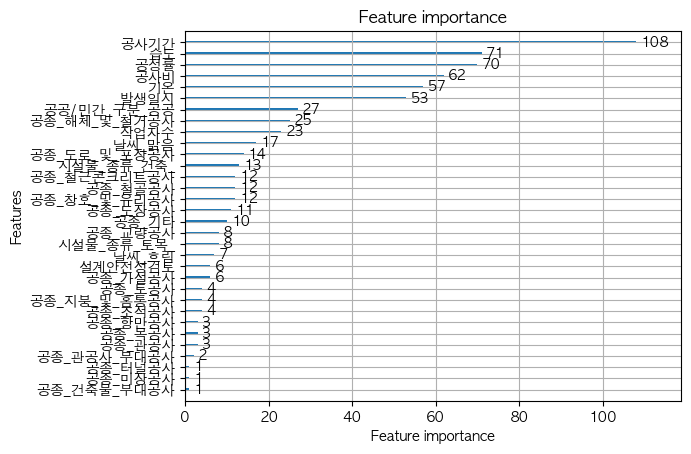

In [27]:
import lightgbm as lgb
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import graphviz

# LightGBM 데이터셋으로 변환
lgb_train = lgb.Dataset(X_train, label=y_train)
lgb_eval = lgb.Dataset(X_test, label=y_test, reference=lgb_train)

# LightGBM 모델 설정
params = {
    'objective': 'regression',
    'metric': ['rmse', 'mae'], # 'set' 대신 'list'로 변경
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'max_depth': 6,
    'min_child_weight': 0.1,
    'verbosity': -1
}

# 모델 학습
num_round = 100
bst = lgb.train(params, lgb_train, num_round, valid_sets=[lgb_train, lgb_eval], early_stopping_rounds=10, verbose_eval=0)

# 모델 예측
y_pred = bst.predict(X_test, num_iteration=bst.best_iteration)

# 예측값과 실제값의 MSE 계산
mse = mean_squared_error(y_test, y_pred)
print("MSE:", mse)

plt.rcParams['font.family'] = 'AppleGothic'

# 모델 feature importance 출력
lgb.plot_importance(bst)
plt.show()


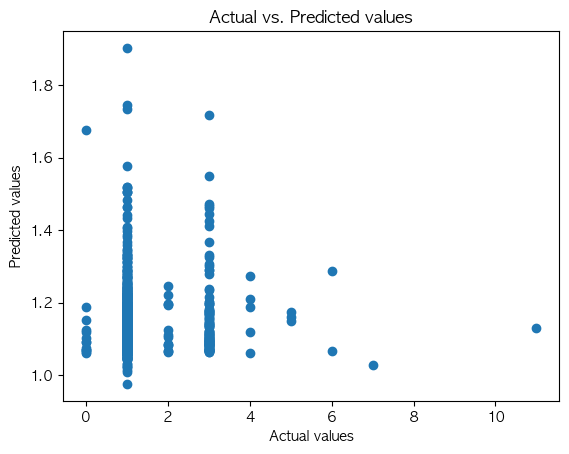

/Users/matmang/opt/anaconda3/envs/bert-study/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


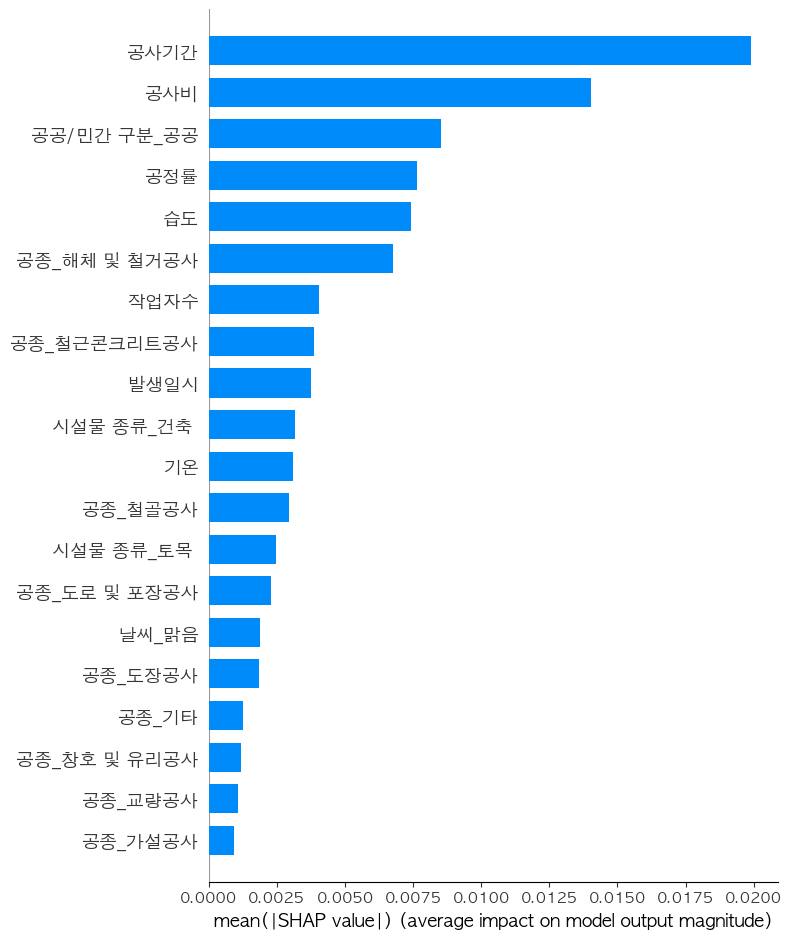

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


In [28]:
# 예측값과 실제값의 분포 확인
plt.scatter(y_test, y_pred)
plt.xlabel('Actual values')
plt.ylabel('Predicted values')
plt.title('Actual vs. Predicted values')
plt.show()

# SHAP 값을 계산하여 feature importance와 함께 시각화
import shap

explainer = shap.TreeExplainer(bst)
shap_values = explainer.shap_values(X_test)

shap.summary_plot(shap_values, X_test, plot_type="bar")
plt.show()

# 모델의 예측값을 해석 가능한 형태로 변환하여 출력
import eli5

# 모델을 ELI5 형태로 변환
model_for_eli5 = lgb.LGBMRegressor(**params)
model_for_eli5.fit(X_train, y_train)

# feature importance와 함께 예측 결과 해석
eli5.show_prediction(model_for_eli5, X_test.iloc[0], feature_names=X_test.columns.tolist(), show_feature_values=True)
